# Экспериментальная лингвистика

## Домашнее задание 3

    Задание: на основании данных эксперимента
    • Построить основную и альтернативную гипотезу (одну или несколько) о закономерностях, наблюдаемых в данных
    • Проверить гипотезу с помощью статистических критериев, прокомментировать результаты:
        o Критерий t-Стьюдента об однородности выборок
        o Критерий Вилкоксона
        o Дисперсионного анализа ANOVA
    • Для любых двух величин:
        o построить матрицу сопряженности, применить к матрице критерий хи-квадрат, прокомментировать результат
        o сформулировать гипотезу о корреляции двух величин, проверить с помощью статистического критерия 
        (корреляция Пирсона/Спирмена), прокомментировать результат

In [1]:
import pandas as pd
import scipy
import numpy as np
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2
import seaborn as sns

In [2]:
# данные экспериментов
df = pd.read_excel('data_lecture_3_tACS.xlsx')
df.head()

,participant,stim_order,condition,AL,L1,answer,score,RT,task,session
0,0,RS,real,derartu,samolet,down,1.0,2.541925,AFC,train
1,0,RS,real,asamu,shprits,right,1.0,1.794262,AFC,train
2,0,RS,real,farimu,konvert,down,1.0,1.989078,AFC,train
3,0,RS,real,vortule,roza,left,1.0,1.904852,AFC,train
4,0,RS,real,topeme,terka,right,1.0,1.839869,AFC,train


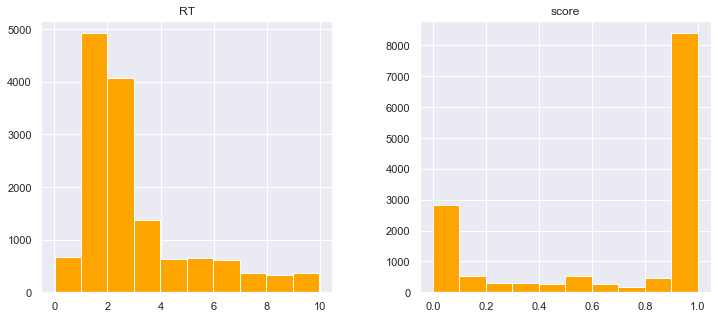

In [3]:
sns.set(rc={'figure.figsize':(12,5)})

ax=df[['score','RT']].hist(color='orange' )

Комментарий от преподавателя по поводу небинарных значений score: _"1 - верный, все остальное неверное"_

Как и в прошлом дз, сразу заменим все score < 1 на 0:

In [4]:
df.loc[df['score'] < 1, 'score'] = 0

Супер!

Теперь, для дальнейшего статистического анализа, группируем данные экспериментов по id участников, сессии (train/test), заданию, условию (настоящая/плацебо стимуляция), порядку стимуляций (RS/SR); считаем сумму score и среднее RT (только для правильных ответов):

In [5]:
df_total = []

for (p_id, session, task, condition), groupdf in df.groupby(['participant', 'session', 'task', 'condition']):
    df_total.append({'participant': p_id, 
                     'session': session,
                     'task': task,
                     'condition': condition,
                     'stim_order': groupdf['stim_order'].unique().tolist()[0],
                     'score': groupdf['score'].sum(),
                     'mean_RT': groupdf[groupdf['score'] == 1]['RT'].mean()})
    
df_total = pd.DataFrame(df_total)
df_total.head()

,condition,mean_RT,participant,score,session,stim_order,task
0,real,1.546667,0,22.0,test1,RS,SEM
1,sham,1.481284,0,28.0,test1,RS,SEM
2,real,4.878153,0,1.0,test1,RS,recall
3,sham,4.516147,0,1.0,test1,RS,recall
4,real,1.659898,0,19.0,test1,RS,recognition


In [6]:
df_total.shape

(480, 7)

In [7]:
# мета-данные
meta_df = pd.read_excel('data_tACS_meta.xlsx', names=['id','sex','age',
                                                      'languages','degree','years','lefthand','family_lefthand'])
meta_df.head()

,id,sex,age,languages,degree,years,lefthand,family_lefthand
0,0,m,33,"Английский, немецкий",Высшее,16.0,нет,нет
1,1,m,25,"Английский: B1, немецкий: А1, белорусский: B1",Высшее,16.0,нет,нет
2,2,m,38,Английский: B1,Высшее,16.0,нет,Да
3,3,f,22,"Английский: С1, китайский: начальный, итальянс...",Высшее,16.0,нет,нет
4,4,f,22,Английский: B1,Высшее,15.5,нет,нет


In [8]:
meta_df.shape

(30, 8)

### Гипотезы:

Гипотезы об эффекте condition/order на score/RT я проверяла в предыдущем дз2 и пришла к выводу, что электрическая стимуляция не влияет на правильность и скорость ответов участников, однако порядок испытаний имеет значениее: вне зависимости от качества стимуляции (реальная или плацебо), на втором этапе эксперимента участники отвечают быстрее. 

Другая пара гипотез, которую мне было бы интересно проверить: корреляция кол-ва иностранных языков' и точности выполнения заданий. В данном случае я буду рассматривать кол-во знакомых участнику иностранных языков как условную меру его опыта в изучении новой лексики. Можно предположить, что человек, которому доводилось учить более одного иностранного языка, будет лучше справляться с заданиями на запоминание новых слов, чем тот, кто изучал только однин родной язык (потому что для первого такого рода деятельность более привычна, чем для второго). Соответственно, чем больше языков человек учил - тем более у него развиты соответствующие навыки и тем выше будут его баллы за задания.

' - пока что это колонка "languages" в meta_df, после обработки добавлю отдельную колонку с соответствующей количественной переменной.

**FL H0 (отсутствие эффекта изучения нескольких иностранных языков):** кол-во знакомых участнику иностранных языков (FL >1) не коррелирует с точностью выполнения заданий (score).

**FL H1 (эффект изучения нескольких иностранных языков есть):** кол-во знакомых участнику иностранных языков >1 коррелирует с точностью выполнения заданий.

In [9]:
FL_list = [len(meta_df['languages'][i].split(',')) for i in range(meta_df.shape[0])]

In [10]:
meta_df['FL'] = FL_list
meta_df.head()

,id,sex,age,languages,degree,years,lefthand,family_lefthand,FL
0,0,m,33,"Английский, немецкий",Высшее,16.0,нет,нет,2
1,1,m,25,"Английский: B1, немецкий: А1, белорусский: B1",Высшее,16.0,нет,нет,3
2,2,m,38,Английский: B1,Высшее,16.0,нет,Да,1
3,3,f,22,"Английский: С1, китайский: начальный, итальянс...",Высшее,16.0,нет,нет,3
4,4,f,22,Английский: B1,Высшее,15.5,нет,нет,1


Чтобы понять, по какой границе делить участников на более-менее равные выборки, посмотрим на распределение кол-ва иностранных языков:

In [11]:
meta_df['FL'].describe()

count    30.000000
mean      1.733333
std       0.868345
min       1.000000
25%       1.000000
50%       1.500000
75%       2.000000
max       4.000000
Name: FL, dtype: float64

Медиана (50%) равна 1.5, то есть (учитывая, что у нас только целочисленные показатели в столбце FL) у нас будет одна выборка, где люди знают только 1 иностранный язык, и вторая выборка, где люди знают 2 и больше.

In [12]:
one_meta_df = meta_df.loc[(meta_df['FL'] == 1)] # выборка участников, изучавших 1 ин.яз.
one_meta_df.head()

,id,sex,age,languages,degree,years,lefthand,family_lefthand,FL
2,2,m,38,Английский: B1,Высшее,16.0,нет,Да,1
4,4,f,22,Английский: B1,Высшее,15.5,нет,нет,1
6,6,m,29,нет,Среднее,13.0,нет,нет,1
7,7,m,21,Английский: С1,Высшее,15.0,нет,нет,1
9,9,m,27,Английский: B2,Высшее,18.0,нет,нет,1


In [13]:
one_meta_df.shape

(15, 9)

In [14]:
more_meta_df = meta_df.loc[(meta_df['FL'] > 1)] # выборка участников, изучавших 2 и более ин.яз.
more_meta_df.head()

,id,sex,age,languages,degree,years,lefthand,family_lefthand,FL
0,0,m,33,"Английский, немецкий",Высшее,16.0,нет,нет,2
1,1,m,25,"Английский: B1, немецкий: А1, белорусский: B1",Высшее,16.0,нет,нет,3
3,3,f,22,"Английский: С1, китайский: начальный, итальянс...",Высшее,16.0,нет,нет,3
5,5,f,25,"Английский: С1, Французский: B1",Высшее,17.0,нет,нет,2
8,8,f,22,"Английский С1, французский: начальный,индонези...",Высшее,16.0,нет,нет,3


In [15]:
more_meta_df.shape

(15, 9)

Получилось как раз поровну, ура!
Теперь надо разбить данные экспериментов на эти 2 выборки по id участников:

In [16]:
one_ids = list(one_meta_df['id'])

# выборка результатов участников, изучавших 1 ин.яз

one_df = df_total.apply(lambda row: row[df_total['participant'].isin(one_ids)])
one_df.head()

,condition,mean_RT,participant,score,session,stim_order,task
32,real,NaN,2,0.0,test1,RS,SEM
33,sham,1.877448,2,16.0,test1,RS,SEM
34,real,5.719197,2,2.0,test1,RS,recall
35,sham,5.367566,2,1.0,test1,RS,recall
36,real,2.147587,2,27.0,test1,RS,recognition


In [17]:
one_df.shape

(240, 7)

In [18]:
more_ids = list(more_meta_df['id'])

# выборка результатов участников, изучавших 2 и более ин.яз.

more_df = df_total.apply(lambda row: row[df_total['participant'].isin(more_ids)])
more_df.head()

,condition,mean_RT,participant,score,session,stim_order,task
0,real,1.546667,0,22.0,test1,RS,SEM
1,sham,1.481284,0,28.0,test1,RS,SEM
2,real,4.878153,0,1.0,test1,RS,recall
3,sham,4.516147,0,1.0,test1,RS,recall
4,real,1.659898,0,19.0,test1,RS,recognition


In [19]:
more_df.shape

(240, 7)

### Статистические критерии

**Критерий t-Стьюдента** - для сравнения средних показателей выборок, т.е. насколько в среднем первая и вторая выборка различаются по выбранному параметру. Формула: (среднее выборки 1 - среднее выборки 2)/стандартная ошибка'.

' - вычисляется на основе стандартных отклонений параметра у первой и второй выборок.

Если разность средних достаточно большая, а стандартная ошибка очень маленькая, то значение t-критерия будет весьма внушительным. А чем больше t-критерий, тем с большей уверенностью мы можем утверждать, что в среднем первая выборка отличается от второй.

P-уровень значимости (p-value) - вероятность того, что две случайно выбранные группы из первой и второй выборки дадут значение критерия большее или равное тому, которое мы получили (чаще всего без учета его знака).

("Статистика и котики", главы 3-4)

In [20]:
# Критерий t-Стьюдента для score
stats.ttest_rel(one_df['score'], more_df['score'])

Ttest_relResult(statistic=-2.740962707388568, pvalue=0.0065887458654477074)

Значение p-value оказалось < 0.05; значит, мы отвергаем нулевую гипотезу (H0) и принимаем альтернативную (Н1): эффект изучения иностранных языков для score есть!

***

**Критерий Вилкоксона** - непараметрический аналог t-критерия Стьюдента (т.е. не использующий в своей формуле среднее значение).

Итак, чтобы его найти, вычислим разности между состоянием до и после для каждого объекта. Затем поставим эти разности в один ряд, от самой большой до самой маленькой, назначив им ранги. При этом знак разности не учитывается. Теперь снова разделим разности на положительные и отрицательные и посчитаем суммы рангов. Логика здесь такая: чем сильнее суммы рангов будут различаться между собой, тем сильнее отрицательный или положительный эффект.

("Статистика и котики", глава 7)

In [21]:
# Критерий Вилкоксона для score
stats.wilcoxon(one_df['score'], more_df['score'])

WilcoxonResult(statistic=9171.0, pvalue=0.0029841667738170724)

Значение p-value снова оказалось < 0.05; значит, мы отвергаем нулевую гипотезу (H0) и принимаем альтернативную (Н1): эффект изучения иностранных языков для score есть!

***

**Дисперсионный анализ ANalysis Of VAriance (ANOVA)** — это статистический метод, который используется для сравнения средних значений двух или более выборок. Он позволяет определить, различаются ли средние значения между группами, или же различия случайны. 

**Однофакторный ANOVA** (однофакторный дисперсионный анализ) – это метод статистического анализа данных, который используется для определения наличия статистически значимых различий между двумя или более группами по одной независимой переменной. 

Входными данными для однофакторного ANOVA являются значения зависимой переменной и групповой фактор, на основе которых проводится анализ. Фактор может быть любой номинальной или порядковой переменной, которая разделяет выборку на группы (в простом случае, это может быть пол, возраст, уровень образования и т.д.). Зависимая переменная – это та переменная, которую мы хотим сравнить в различных группах.

Однофакторный ANOVA проверяет нулевую гипотезу о том, что среднее значение зависимой переменной одинаково во всех группах. Если p-значение меньше заданного уровня значимости (обычно 0.05), тогда мы можем сделать вывод о том, что средние значения по группам различаются статистически значимо друг от друга.

F-статистика (F-значение) измеряет различия между группами, то есть отношение между средними значениями в группах и дисперсией внутри групп. Если F-значение большое, то это указывает на статистически значимые различия между группами.

p-value (вероятность) - это вероятность того, что различия между группами были случайными и не связаны с фактором, который изучается. Если p-value меньше выбранного уровня значимости, то можно отбросить нулевую гипотезу и утверждать, что между группами есть статистически значимые различия.

Важно знать, что F-статистика и p-value не являются самостоятельными критериями для определения статистической значимости. Они должны использоваться вместе с другими статистическими методами для получения более точных результатов.

**Многовариантный ANOVA** (analysis of variance) — это статистический метод, который используется для анализа различий между группами (факторами) и влияния различных переменных (факторов) на исследуемую зависимую переменную. Он позволяет выявить, есть ли статистически значимое влияние одного или нескольких факторов на зависимую переменную, и определить, какие из факторов оказывают наибольшее влияние.

Многовариантный ANOVA может использоваться для анализа различных типов данных, включая непрерывные, дискретные и категориальные переменные. Он также может рассчитываться для различных уровней взаимодействия между факторами, что позволяет учитывать сложные взаимодействия между переменными.

https://habr.com/ru/companies/otus/articles/734258/

In [22]:
# однофакторный дисперсионный анализ для score

f_oneway(one_df['score'], more_df['score'])

F_onewayResult(statistic=1.4265356027436153, pvalue=0.23292299795773708)

Значение pvalue большое, сильно больше 0.05. На основе этого результата мы должны принять нулевую гипотезу о том, что эффекта нет, хотя два предыдущих критерия показали обратное...

Попробуем применить многофакторный анализ. Для этого добавим данные о возрасте к данным эксперимента:

In [23]:
df_total_id_list = [row['participant'] for i, row in df_total.iterrows()]

df_total['FL'] = [int(meta_df.loc[(meta_df['id'] == id_item), 'FL']) for id_item in df_total_id_list]

df_total.head()

,condition,mean_RT,participant,score,session,stim_order,task,FL
0,real,1.546667,0,22.0,test1,RS,SEM,2
1,sham,1.481284,0,28.0,test1,RS,SEM,2
2,real,4.878153,0,1.0,test1,RS,recall,2
3,sham,4.516147,0,1.0,test1,RS,recall,2
4,real,1.659898,0,19.0,test1,RS,recognition,2


In [24]:
# многофакторный дисперсионный анализ для score

formula = 'score ~ C(FL) + C(condition) + C(stim_order)'
model = ols(formula, df_total).fit()
aov_table = anova_lm(model, typ=2)

aov_table

,sum_sq,df,F,PR(>F)
C(FL),371.529306,3.0,0.844395,0.470055
C(condition),1.200000,1.0,0.008182,0.927965
C(stim_order),19.395973,1.0,0.132247,0.716276
Residual,69519.187360,474.0,NaN,NaN


Значение pvalue для всех выбранных факторов больше 0.05. При этом у количества знакомых языков этот показатель ниже всех, но всё ещё больше 0.05. На основе этого результата мы должны принять нулевую гипотезу о том, что эффекта изучения более одного иностранного языка нет. При этом важно заметить, что других эффектов здесь тоже не наблюдается.

### Таблица сопряженности 

средство представления совместного распределения двух переменных, предназначенное для исследования связи между ними. 

Рассмотрим совместоне распределение score и FL:

In [25]:
df_total['score_quart'] = df_total['score'].apply(lambda x: x // (df_total['score'].max() // 4))

contingency=pd.crosstab(df_total['score_quart'], df_total['FL'])
contingency

FL,1,2,3,4
score_quart,,,,
0.0,87,44,32,6
1.0,10,9,1,0
2.0,80,42,18,5
3.0,62,45,27,5
4.0,1,4,2,0


На первый взгляд выглядит так, словно моя гипотеза в корне не верна :)

**Критерий Хи-квадрат Пирсона**

Все вышеперечисленные критерии замечательно работают в случаях, когда нам известны точные или хотя бы приблизительные значения выбранного параметра для двух выборок. Однако такие ситуации встречаются далеко не всегда. Иногда мы можем иметь только указание на то, большое или маленькое значение параметра у объекта. В таких нелегких условиях определить различия между выборками нам поможет критерий Хи-квадрат Пирсона.

Чтобы вычислить этот критерий, нужно построить так называемые таблицы сопряженности. В простейшем случае это таблицы 2х2, каждой ячейке которых — кол-во (т.е. частота) объектов выборки с  определенным значением параметра. Впрочем, бывают таблицы сопряженности и с бОльшим количеством столбцов и строчек.

И основная идея критерия Хи-квадрат состоит в том, чтобы сравнить такую таблицу, в которой выборка 1 не отличается от выборки 2 (иначе — таблицу теоретических частот), с той, что есть у нас (таблицей эмпирических частот).

("Статистика и котики", глава 3)

In [26]:
stats.chi2_contingency(contingency)[:2]

(13.778973801167187, 0.3150448113810907)

Значение pvalue снова сильно больше 0.05. Получается, что связи между кол-вом изученных иностранных языков и точностью выполнения заданий нет.

### Корреляции

In [27]:
df_total[['score', 'FL', 'mean_RT']].corr()

,score,FL,mean_RT
score,1.000000,0.021877,-0.814793
FL,0.021877,1.000000,-0.016507
mean_RT,-0.814793,-0.016507,1.000000


Гипотеза: чем дольше человек думает над ответом, тем неправильнее он отвечает в результате (видимо, потому что не знает и вспомнить так и не удалось).

**Корреляция Спирмена** - чтобы его вычислить, упорядочим выборку по параметру 1 (по убыванию) и присвоим им ранги. Затем мы перераспределим их по параметру 2 (так же по убыванию) и присвоим им ранги уже по этому признаку. Если результаты обоих ранжирований будут совпадать между собой, то мы можем констатировать положительную связь, если же они будут диаметрально противоположными — отрицательную. Критерий Спирмена мы получаем, применив специальную формулу к нашим рангам, и он интерпретируется аналогично r-критерию Пирсона: он может изменяться в пределах от -1 до 1, где -1 — отрицательная связь, +1 положительная связь, а 0 — отсутствие всякой связи.


("Статистика и котики", глава 9)

In [28]:
df_total.dropna(inplace=True)

In [29]:
rho, p = stats.spearmanr(df_total.mean_RT, df_total.score)
rho, p

(-0.6795522930004186, 3.5955058320837244e-61)

Если я правильно поняла как интерпретировать эти числа, то между mean_RT и score существует отрицательная корреляция, т.е. чем больше времени человек тратит на ответ, тем хуже его результаты. Тогда эта гипотеза подтверждается!